We begin by loading the data, which is a text file where the first column is the fault-perpendicular distance and the second column is the fracture or aftershock density at that distance, or the strain intensity at that distance. This text file was generated using Matlab code that is also available as part of this package. Sorry I used different languages. We do provide the output text files for those without access to Matlab.

This code is largely based on tutorials by the notebook community https://notebook.community/obscode/bootcamp/MoreNotebooks/ModelFitting/Emcee and by Imad Pasha https://github.com/prappleizer/prappleizer.github.io/blob/master/Tutorials/MCMC/MCMC_Tutorial_Solution.ipynb. The documentation for emcee is available here http://dan.iel.fm/emcee/current/user/line/.

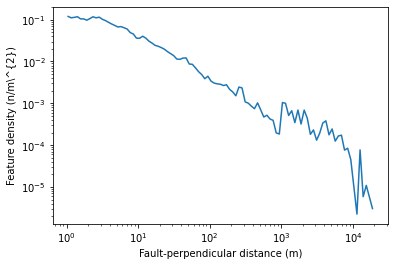

In [19]:
# import a few packages that we will use
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import emcee # this package does the MCMC

# load sample data (density decay text files produced from Matlab script)
AR_decay = np.loadtxt('Ridgecrest_mainshock_density_decay.txt', delimiter=',')
x = AR_decay[:,0] # fault-perpendicular distance in meters
density = AR_decay[:,1] # feature density at a given distance (per sqm)

# double-check data is properly loaded by plotting it
plt.figure()
plt.plot(x,density)
plt.ylabel('Feature density (n/m\^{2})')
plt.xlabel('Fault-perpendicular distance (m)')
plt.yscale('log')
plt.xscale('log')
plt.show()

In the next cell, we define the model that we will be fitting out data with. We use the expression from Powers and Jordan (2010): 

\begin{equation}
\nu(x) = \nu_o\left(\frac{d^{m}}{|x|^{m}+d^{m}}\right)^{\frac{\gamma}{m}}
\end{equation}

where $\nu$ is the fracture density at a given distance away from the fault, $\nu_o$ is the fracture density at x = 0, d (meters) represents the distance between the origin and a break in scaling, m represents the sharpness of the corner, and $\gamma$ represents the decay exponent or slope past point d. 

In [20]:
def model(theta,density=density):
    v_o,d,gamma = theta # we store our parameters in a variable named theta
    return v_o * (d**2/((abs(x)**2+d**2)))**(gamma/2) # see explanation for m=2 below
# V0 ((x/d)^m + 1)^-(gamma/m)

We next need a function that will tell us how well the given set of parameters fits the data using our model. We assume that the error in density at a given location is Poissonian (Powers and Jordan, 2010). 

In [21]:
def lnlike(theta, x, y):
    v = model(theta,x)
    return np.sum((-y/v)-np.log(v))

# # Poisson distribution

#return -0.5 * np.sum(((y - model(theta, x))/0.01) ** 2)
    # 1 / (1+ np.exp(-estParms[0]*(xdata-estParms[1])))
    #mu = model(theta,x)
    #return np.sum(np.log(poisson.pmf(y,mu)))
    #log(p) = np.log(1/v)+log(-y/v)-log(v)
    #return np.sum(-y*np.log(mu)+(-mu)-np.sum(np.log(np.arange(y))))

We will next assign a set of priors to our runs. These priors tell the model what reasonable value ranges for $v_o$, d, and $\gamma$ are. It is important that these priors are not too tight, otherwise we will overconstrain the model. More discussion on assessing whether the prior range is appropriate is provided below when we assess the co-variance of the parameter fits.

We simply read a reasonable range off the first plot but a fit using scipy.optimize would also yield a more rigorous starting point. That's probably overkill and we are already being fancy enough with the MCMCs here. The quality of the starting fit helps the model converge faster but it should not affect the final fits if run for long enough. 

Note that we fit m to the data instead of keeping a fixed value like Powers and Jordan (2010) did (m=2). The quality of fits does not vary significantly with corner sharpness, as demonstrated in the Powers and Jordan paper. 

In [22]:
def lnprior(theta):
    v_o,d,gamma = theta
    if 0 < v_o < 1 and 0.0 < d < 2000.0 and 0 < gamma < 2:
        return 0.0
    else:
        return -np.inf

The last function we need to define is lnprob(). This function combines the steps above by running the lnprior function, and if the function returned -np.inf, passing that through as a return, and if not (if all priors are good), returning the lnlike for that model (by convention we say it's the lnprior output + lnlike output, since lnprior's output should be zero if the priors are good). lnprob needs to take as arguments theta (the priors), x, and density, since these get passed through to lnlike.

In [23]:
def lnprob(theta, x, y): # this function will call lnlike and lnprior, which we created above
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, x, y)

We have to create a number of walkers and start them off in random locations around parameter space. Anything around 200 walkers should yield a reasonable solution. Increasing army size beyond that mostly increases model run time with huge diminishing returns to fits.

We start our walkers off at initial guesses for $v_o$, d, and $\gamma$. If we didn't know decent approximations, we could start in completely random locations or use other tools (like curve_fit) to find an initial starting point. Why do that if we can decrease our model run time with decent guesses.

In [24]:
data = (x,density) # pretty straight forward, the variables we defined in the first box. 
nwalkers = 200 # army size
niter = 20000 # number of iterations. For this particular case, convergence starts in the 100s so running to ~2000 seems to be enough.
# A higher number of iterations will be required if the initial guesses are worse. Analysis of parameter distributions
# (we will do this later) can easily inform whether we have run our model for enough iterations. 
initial = np.array([0.001,3,1.1]) # initial guesses for v_o, d, gamma, and m
ndim = len(initial)   # number of dimensions is just number of variables
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)] # defines stepping step from one place in grid to the next

We are now ready to run the MCMC. The next cell sets this up in a function named main and it is pretty much lifted from the emcee documentation directly. We can run the emcee sampler, givin it the lnprob function and any extra arguments it needs. The run_mcmc function takes the initial starting points and how many steps you want each to take. It returns the last position, probability, and state of each walker.

In [25]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 10000)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

Ok time to actually run the thing. This will be the most time consuming step in the process.

Reference times: 

Run time for 200 walkers and 2,000 iterations is length of quick twitter check

Run time for 200 walkers and 20,000 iterations is length of bathroom break

Run time for 200 walkers and 200,000 iterations is length of meal

Run time for 200 walkers and 2,000,000 is a few hours of a different task

In [26]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


Let's take a look at the different runs

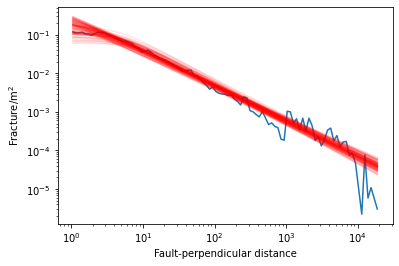

In [27]:
#sampler= main(p0)
def plotter(sampler,density=density,x=x):
    plt.ion()
    plt.plot(x,density)
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(x, model(theta, x), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Fault-perpendicular distance')
    plt.ylabel('Fracture/m$^{2}$')
    #plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.show()
    
plotter(sampler)

Now let's see what each walker did. We'll graph the value of each parameter as a function of step number. Each walker will have its own line.

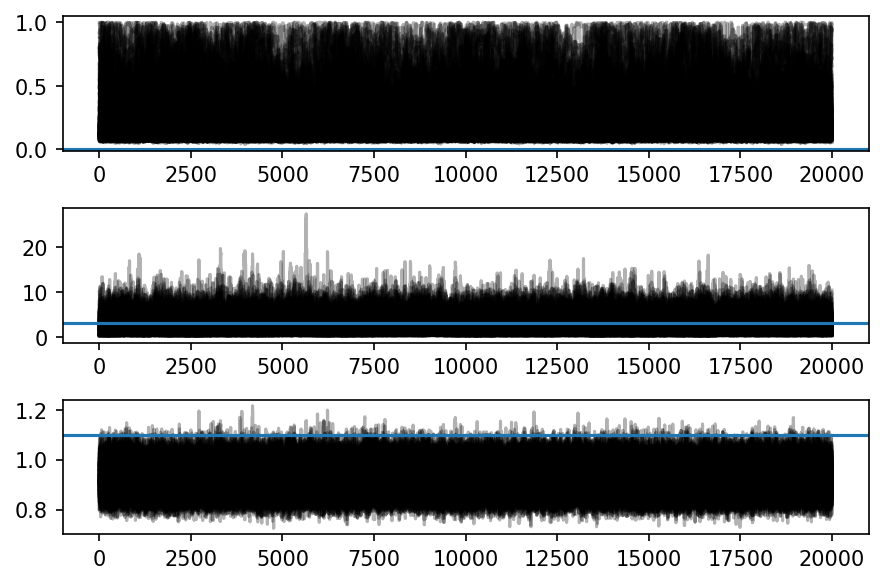

In [28]:
fig,ax = plt.subplots(3,1,dpi=150)
res = [ax[i].plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.3) for i in range(3)]
res = [ax[i].axhline(initial[i]) for i in range(3)]
plt.tight_layout()

# save chain
np.savetxt('Ridgecrest_mainshock_chain.txt',np.column_stack((sampler.chain)))

Let's quicky print the preferred values for each parameters

In [29]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)] #v_o d gamma m

array([0.13619482, 2.59791753, 0.91667967])

We also check our acceptance fraction 

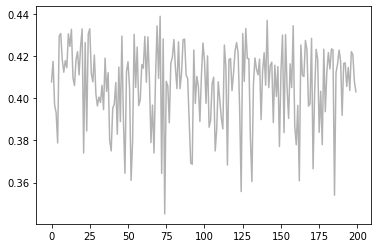

In [30]:
plt.plot(sampler.acceptance_fraction, '-', color='k', alpha=0.3)
#plt.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)

Let's visualize the best fit and 1-sigma range


In [31]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples)

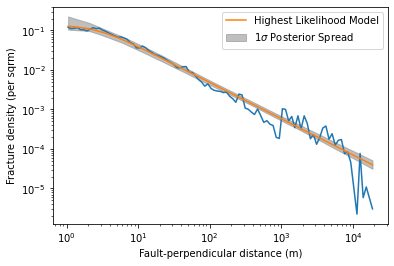

In [32]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(x,density)
plt.plot(x,best_fit_model,label='Highest Likelihood Model')
plt.fill_between(x,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Fracture density (per sqrm)')
plt.xlabel('Fault-perpendicular distance (m)')
plt.legend()
plt.savefig('Ridgecrest_mainshock.pdf')
plt.show()

Lastly, we can visualize the posterior probabilities of the parameters as well as the covariances between them by plotting a corner plot. We will save this plot as a pdf.

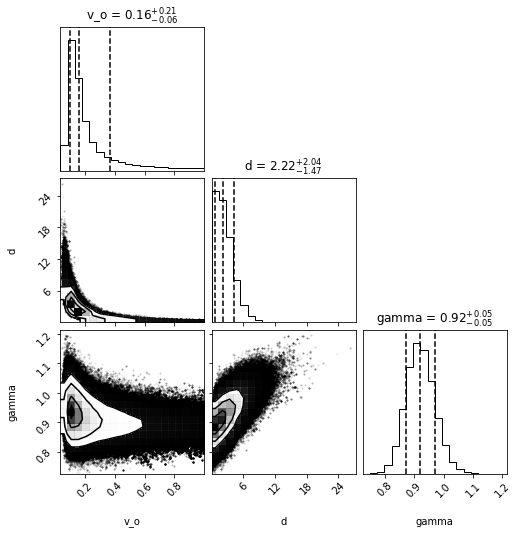

In [33]:
import corner
labels = ['v_o','d','gamma','m']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
plt.savefig('corner_error_corr_Ridgecrest_mainshock.pdf')

In [34]:
np.savetxt('Ridgecrest_mainshock_parameters.txt',np.column_stack((samples[:,0],samples[:,1],samples[:,2])))

In [ ]:
#fig,ax = plt.subplots(3,1)
#res = [ax[i].hist(sampler.chain[:,:,i].T, 20) for i in range(3)]

Last, we save our best fit model (x and y coordinates), spread, and best fit parameters. 

In [ ]:
np.savetxt('Ridgecrest_mainshock_MCMCfits.txt',np.column_stack((x, best_fit_model)))
np.savetxt('Ridgecrest_mainshock_spread.txt',np.column_stack((med_model, spread)))
np.savetxt('Ridgecrest_mainshock_best_fit_parameters.txt',np.column_stack((samples[np.argmax(sampler.flatlnprobability)])))